In [171]:
import pandas as pd
import numpy as np

# Read the cleaned file into a DataFrame
df = pd.read_csv('../data/bgg_rating_threshold.csv', sep=';', engine='c')

# Convert the 'bgg_user_rating' column to numeric
df['bgg_user_rating'] = ((pd.to_numeric(df['bgg_user_rating'], errors='coerce'))*10).astype(np.uint8)

print("done")

done


In [172]:
from scipy.sparse import coo_matrix,csr_matrix
from sklearn.decomposition import TruncatedSVD
data = list(df.itertuples(index=False, name=None))
# Alternatively, you can use df['item'], df['user'], and df['review_score'] directly.

# Create unique mappings for items and users
unique_items = sorted(df['bgg_id'].unique())
unique_users = sorted(df['bgg_user_name'].unique())

item_to_index = {item: idx for idx, item in enumerate(unique_items)}
user_to_index = {user: idx for idx, user in enumerate(unique_users)}

# Prepare row indices, column indices, and data (review scores) using the DataFrame columns
rows = df['bgg_id'].map(item_to_index)
cols = df['bgg_user_name'].map(user_to_index)
scores = df['bgg_user_rating']

# Create a sparse matrix using the COO format:
sparse_matrix = csr_matrix(
    (scores, (rows, cols)),
    shape=(len(unique_items), len(unique_users))
)

# Optionally convert to CSR format for more efficient arithmetic operations
#sparse_matrix = sparse_matrix.tocsr()
print ("Sparse matrix created with shape:", sparse_matrix.shape)

Sparse matrix created with shape: (15738, 411956)


In [173]:
# # 1) Compute column sums and counts of stored entries
# col_sums   = np.bincount(sparse_matrix.indices, weights=sparse_matrix.data, minlength=sparse_matrix.shape[1])
# col_counts = np.bincount(sparse_matrix.indices, minlength=sparse_matrix.shape[1])

# # 2) Compute column means, with NaN for empty columns
# col_means = col_sums / col_counts
# col_means[col_counts == 0] = np.nan

# # 3) Convert sparse_matrix.data to float64 for compatibility
# sparse_matrix.data = sparse_matrix.data.astype(np.float64)

# # 4) Subtract the column means from each stored entry, in place
# sparse_matrix.data -= col_means[sparse_matrix.indices]

In [174]:
# Display the first 5 rows and columns of the sparse_matrix
print(sparse_matrix[:5, :5])

<Compressed Sparse Row sparse matrix of dtype 'uint8'
	with 1 stored elements and shape (5, 5)>
  Coords	Values
  (4, 2)	80


In [175]:
from sklearn.metrics.pairwise import cosine_similarity
sparse_matrix = cosine_similarity(sparse_matrix, dense_output=True)
np.fill_diagonal(sparse_matrix, 0)  # Set diagonal to zero

In [176]:
# Display the first 5 rows and columns of the sparse_matrix
print(sparse_matrix[:5, :5])

[[0.         0.05124506 0.27243588 0.1296068  0.27745892]
 [0.05124506 0.         0.05905128 0.05030473 0.08138042]
 [0.27243588 0.05905128 0.         0.09861386 0.31927219]
 [0.1296068  0.05030473 0.09861386 0.         0.09513554]
 [0.27745892 0.08138042 0.31927219 0.09513554 0.        ]]


In [177]:
Number_neighbors = 50

In [178]:
import umap
reducer = umap.UMAP(metric='precomputed',n_jobs=-1,min_dist=0.1,n_neighbors=Number_neighbors)
mapper=reducer.fit(np.asarray(1 - sparse_matrix))
coords=reducer.transform(np.asarray(1 - sparse_matrix))

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [179]:
# Get the indices of the top 500 values for each row
top_500_indices = np.argsort(sparse_matrix, axis=1)[:, -Number_neighbors:]

In [180]:
# # Create a new matrix to store the data
filtered_matrix = np.zeros((top_500_indices.shape[0], top_500_indices.shape[1]))

# Populate the matrix with data from sparse_matrix
for row_idx in range(top_500_indices.shape[0]):
    filtered_matrix[row_idx] = sparse_matrix[row_idx, top_500_indices[row_idx]]  # Direct indexing for numpy.ndarray


In [181]:
import igraph as ig

# Extract indices and distances from neigh
# indices, dist, _ = neigh
weightss = filtered_matrix

# Create an edge list with weights
edges = []
weights = []
for i, neighbors in enumerate(np.asarray(top_500_indices)):
    for j, neighbor in enumerate(neighbors):
        if i != neighbor:  # Avoid self-loops
            edges.append((i, neighbor))
            weights.append(weightss[i, j])

# Create the igraph graph
g = ig.Graph(edges=edges, edge_attrs={"weight": weights}, directed=False)
print(g.summary())


IGRAPH U-W- 15738 786900 -- 
+ attr: weight (e)


In [182]:
# t=g.community_leiden(objective_function="modularity", weights="weight")
# print(t.modularity)


In [183]:
# communities = t.membership

In [184]:
#Game–game weighted adjacency
# sparse_matrix = sparse_matrix.dot(sparse_matrix.T).todense()


In [185]:
# sim_matrix=pd.DataFrame(sparse_matrix).corr()

In [186]:
# from sklearn.metrics.pairwise import cosine_similarity

# sparse_matrix = cosine_similarity(sparse_matrix, dense_output=True)


In [187]:
# from sklearn.preprocessing import PowerTransformer

# scaler = PowerTransformer()
# scaler.fit(sparse_matrix)
# sparse_matrix_scaled = scaler.transform(sparse_matrix)

In [188]:
# # Set diagonal values to a very small number to exclude them from the top 500
# np.fill_diagonal(sparse_matrix, -np.inf)
# N = 1500
# # Get the indices of the top N values for each row
# top_N_indices = np.argsort(sparse_matrix, axis=1)[:, -N:]

# # Create a mask to keep only the top N values for each row
# mask = np.zeros_like(sparse_matrix, dtype=bool)
# rows = np.arange(sparse_matrix.shape[0])[:, None]
# mask[rows, top_N_indices] = True

# # Apply the mask to keep only the top N values, set others to 0
# filtered_sparse_matrix = np.where(mask, sparse_matrix, 0)

# # Restore the diagonal values to 0
# np.fill_diagonal(sparse_matrix, 0)

In [189]:
# from sklearn.neighbors import kneighbors_graph
# k = 1500
# # mode='distance' yields distances; mode='connectivity' yields 0/1 links
# knn_dist = kneighbors_graph(sparse_matrix, n_neighbors=k, mode='distance', include_self=False,n_jobs=-1)
# # Convert distances to weights, e.g. w = exp(-d)
# knn_weights = knn_dist.copy()
# knn_weights.data = np.exp(-knn_weights.data)


In [190]:
# import igraph as ig
# 5. Build an igraph Graph from the sparse matrix
#    Note: igraph expects a dense adjacency or edge list with weights
# d=knn_dist.data
# w = knn_weights.data
# g=ig.Graph.Weighted_Adjacency(filtered_sparse_matrix,attr='weight', loops=False)

In [191]:
df_game_item_from_bgg = pd.read_csv('../data/boardgames_ranks.csv') 
namess=[]
i=0
for bgg_id in unique_items:    
   
    namee = df_game_item_from_bgg[df_game_item_from_bgg['id'].isin([bgg_id])]['name']
    namess.append(namee.to_string())
    i=i+1

g.vs["label"] = namess

In [192]:
import leidenalg as la
# partition = g.community_leiden(objective_function="modularity", weights="weight")
partition = la.find_partition(g, la.ModularityVertexPartition, weights='weight')
communities = partition.membership
print(partition.modularity)

0.6155605324737046


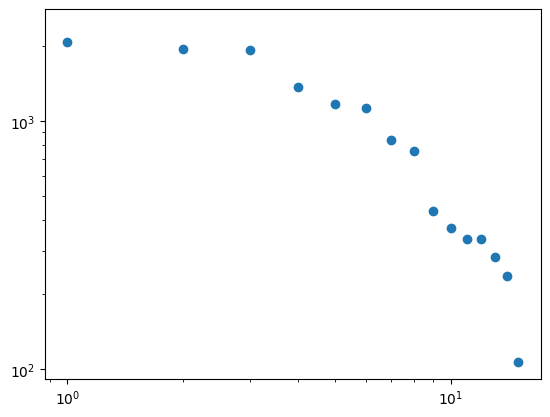

In [193]:
import matplotlib.pyplot as plt

unique_clusters, counts = np.unique(communities, return_counts=True)
cluster_counts = dict(zip(unique_clusters, counts))
plt.loglog(cluster_counts.keys(), cluster_counts.values(), 'o')


In [194]:
indices = [i for i, j in enumerate(communities) if j ==14]
df_game_item_from_bgg = pd.read_csv('../data/boardgames_ranks.csv') 
for index in indices:
    bgg_id = unique_items[index]
    name = df_game_item_from_bgg[df_game_item_from_bgg['id'].isin([bgg_id])]['name']
    print(name.to_string())

5577    Button Men
2517    Illuminati
25378    Falling
27379    Before I Kill You, Mister Spy...
7396    Give Me the Brain!
27389    Devil Bunny Needs a Ham
6050    Groo: The Game
5572    Icehouse
18833    Lunch Money
3310    Kill Doctor Lucky
11032    Fluxx
6294    The Very Clever Pipe Game
4742    Brawl
11143    The Big Cheese
9903    Chez Geek
12338    Parts Unknown
12522    Tile Chess
25240    Escape from Elba
28312    Change!
27278    Q-Turn
7500    Plague & Pestilence
5872    The Big Idea
27964    Gother Than Thou
27646    Maul of America
23381    The Great Brain Robbery
9705    The Hills Rise Wild!
5556    Aquarius
3363    Chrononauts
20249    Battle of the Bands
20293    Ben Hurt
25852    Car Wars: The Card Game
8835    Save Doctor Lucky
6926    Witch Trial
19129    Cults Across America
26633    Safari Jack
11477    Hacker
8959    Starbase Jeff
7404    Cosmic Wimpout
8174    Girl Genius: The Works
27439    Abduction
9364    Deadwood Studios USA
26721    Dino Hunt
23563    Get O

In [195]:
# import umap
# reducer = umap.UMAP()

# filtered_sparse_matrix=np.where(filtered_sparse_matrix > 0, 1 / filtered_sparse_matrix, 0)
# reducer.fit(filtered_sparse_matrix,metric='precomputed')
# coords=reducer.transform(filtered_sparse_matrix)

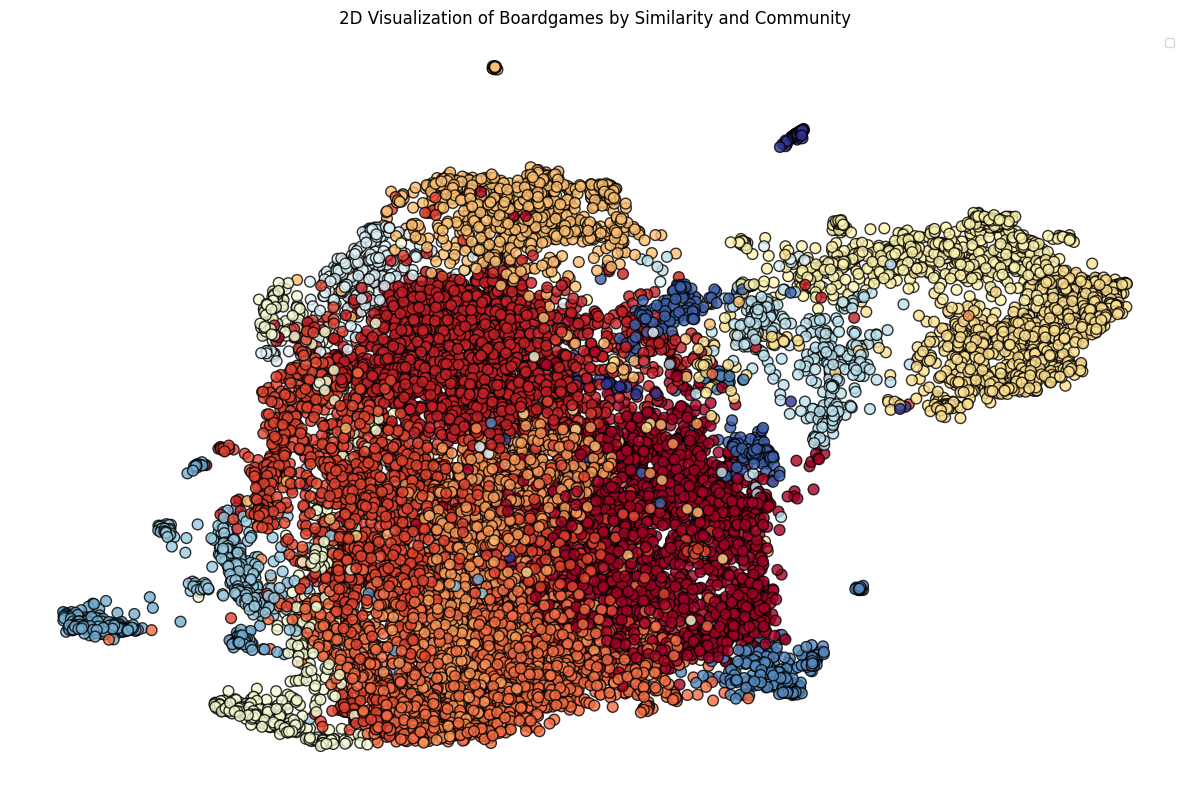

In [196]:
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

# Step 5: Plotting
plt.figure(figsize=(12, 8))

plt.scatter(coords[:, 0], coords[:, 1],c=communities,cmap=plt.cm.RdYlBu ,s=60, alpha=0.8, edgecolor='k')

# Add legend without duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize='small')

plt.title("2D Visualization of Boardgames by Similarity and Community")
plt.axis('off')
plt.tight_layout()
plt.show()

<Axes: >

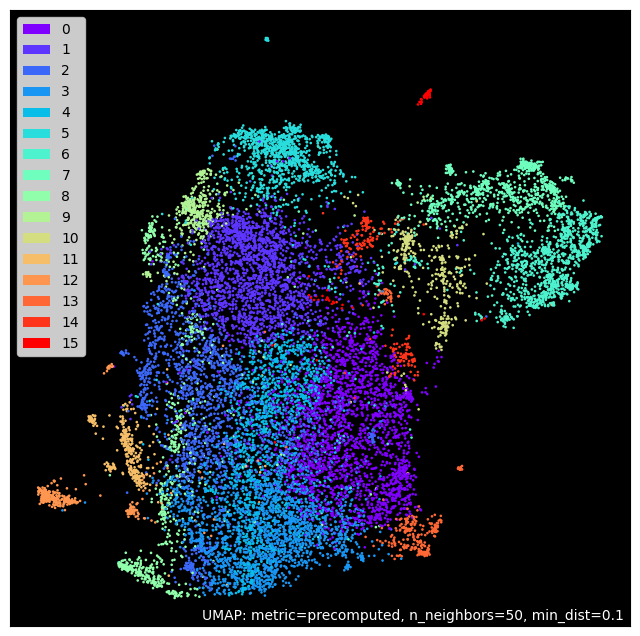

In [197]:
import umap.plot
import numpy as np

# Convert labels to a NumPy array
labels_array = np.array(communities)

# Plot the points
umap.plot.points(mapper, labels=labels_array, theme='fire')

In [198]:
indices = [i for i, j in enumerate(communities)]
df_game_item_from_bgg = pd.read_csv('../data/boardgames_ranks.csv') 
names=[]
i=0
for index in indices:    
    bgg_id = unique_items[index]
    name = df_game_item_from_bgg[df_game_item_from_bgg['id'].isin([bgg_id])]['name']
    names.append(name.to_string())
    i=i+1
hover_data = pd.DataFrame({'Name':np.array(names)})



In [199]:
umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=labels_array, hover_data=hover_data, point_size=4,background='black')
umap.plot.show(p)

Loading BokehJS ...

In [200]:
# umap.plot.connectivity(mapper, edge_bundling='hammer')

In [201]:
clustered_graph =partition.cluster_graph("random","sum")

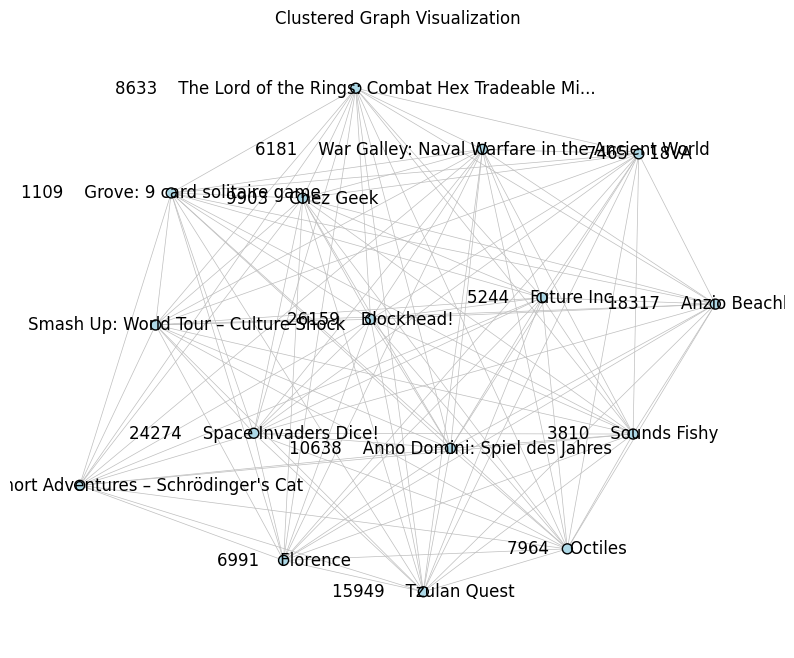

In [202]:
import igraph as ig

import matplotlib.pyplot as plt

# Plot the clustered_graph using igraph's built-in plotting
layout = clustered_graph.layout("fr")  # Fruchterman-Reingold layout
fig, ax = plt.subplots(figsize=(10, 8))
ig.plot(
    clustered_graph,
    target=ax,
    layout=layout,
    vertex_size=10,
    vertex_color="lightblue",
    edge_width=0.5,
    edge_color="gray",
    bbox=(800, 600),
)
plt.title("Clustered Graph Visualization")
plt.show()

In [203]:
clustered_graph.write_dot("../graph/clustered_graph.dot")


In [204]:
i=0
for subgraph in partition.subgraphs():
    subgraph.write_dot(f"../graph/subgraph_{i}.dot")
    i+=1